In [4]:
import sys; sys.path.append('..')

In [1]:
import sqlite3
import pandas as pd
from IPython.display import display

# Connect to sqlite database and get all truthed roadways with no obscuration that are valid
with sqlite3.connect('file:/data/road_surface_classifier/features.sqlite3?mode=ro', uri=True) as con:
    cursor = con.cursor()
    cursor.execute("""
        SELECT osm_id, chip_path from features
        WHERE obscuration = 0 AND no_data = 0 and bad_detect = 0
        GROUP BY chip_path HAVING COUNT(*) == 1;
    """)
    rows = cursor.fetchall()

# Put this all in a dataframe
df = pd.DataFrame(rows, columns=['osm_id', 'chip_path']).set_index('osm_id')

# Load OSM features and extract WKT values for the OSM IDs from above
osm_df = pd.read_csv('/data/road_surface_classifier/features.csv')
osm_df = osm_df.set_index('osm_id').loc[df.index][['wkt', 'x', 'y']]

# Combine this with our original DataFrame to get a "super-duper" DataFrame with wkt values
df = pd.concat([df, osm_df], axis=1)
display(df)

,chip_path,wkt,x,y
osm_id,,,,
220524584,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-118.6039449 48.8811062,-118.60421...",22352.496094,45082.347656
220510329,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-122.4671105 48.7221132,-122.46710...",20946.546875,45164.402344
489520699,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-116.9723772 48.6753545,-116.97302...",22943.601562,45188.054688
211113429,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-109.78988 48.5106693,-109.7870083...",25574.140625,45274.113281
215456191,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-122.3390078 48.4875362,-122.33937...",20984.527344,45286.015625
...,...,...,...,...
200703849,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-80.372727 25.543792,-80.3727487 2...",36272.214844,55910.953125
198378350,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-80.3757602 25.5444369,-80.3757649...",36271.574219,55911.421875
198378556,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-80.3797366 25.5380064,-80.3797369...",36270.125000,55912.578125


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

# Take a random sample
s = df
#s = df.sample(n=250, random_state=1234)

# Plot the sample
# fig, ax = plt.subplots(1, len(s), figsize=(10,3))
# fig.tight_layout(pad=0, w_pad=0, h_pad=0)
# for idx, ax_ in enumerate(ax):
#     im_path = s.iloc[idx]['chip_path']
#     im = np.array(PIL.Image.open(im_path))
#     ax_.imshow(im)
#     ax_.get_xaxis().set_visible(False)
#     ax_.get_yaxis().set_visible(False)

UsageError: Line magic function `%s` not found.


In [3]:
from osgeo import ogr
ogr.UseExceptions()

import PIL.Image
import PIL.ImageDraw

from data_prep.utils import wgs84_to_im

def create_mask(row, width=2):    
    # Get list of points from WKT
    geom = ogr.CreateGeometryFromWkt(row['wkt'])
    pts = np.array(
        [geom.GetPoint_2D(idx) for idx in range(geom.GetPointCount())])
    lon_ar, lat_ar = pts[:, 0], pts[:, 1]

    # Convert to image-space x, y
    ix, iy = wgs84_to_im(lon_ar,
                            lat_ar,
                            row['x'],
                            row['y'],
                            z=17,
                            iw=256,
                            ih=256)

    # Load image
    im = np.array(PIL.Image.open(row['chip_path']))

    # Create a new image of the same shape, and draw a line
    # to create a mask
    mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
    mask_pil = PIL.Image.new('L', ((im.shape[1], im.shape[0])), color=0)
    d = PIL.ImageDraw.Draw(mask_pil)
    d.line(
        [(x, y) for x, y in zip(ix, iy)],     # type: ignore
        fill=255,
        width=width, # Original: 10,
        joint="curve")
    mask = np.array(mask_pil)
    return im, mask

In [5]:
import skimage.color
from data_prep.geometric_median import geometric_median

def avg_color(im, mask):
    im_lab = skimage.color.rgb2lab(im[np.where(mask)]).reshape((-1, 3))
    avg_color_lab = geometric_median(im_lab)
    # avg_color_lab = np.median(im_lab[np.where(mask)], axis=0)
    return avg_color_lab

In [6]:
%matplotlib widget

from tqdm import tqdm

pos_sample_list = []
neg_sample_list = []

for idx in tqdm(range(len(s))):
    row = s.iloc[idx]
    
    # Gen positive sample
    im, mask = create_mask(row, width=2)
    pos_avg = avg_color(im, mask)
    pos_sample_list.append(pos_avg)

    # Gen negative sample
    im, mask = create_mask(row, width=25)
    _, mask_2 = create_mask(row, width=50)
    neg_avg = avg_color(im, mask_2 & ~mask)
    neg_sample_list.append(neg_avg)


pos_sample_list = np.array(pos_sample_list)
neg_sample_list = np.array(neg_sample_list)

100%|██████████| 4630/4630 [01:16<00:00, 60.90it/s]


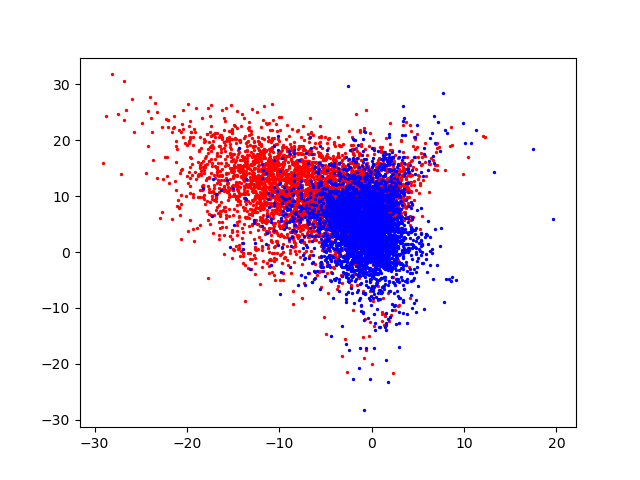

In [7]:
%matplotlib widget

fig, ax = plt.subplots()
ax.scatter(neg_sample_list[:, 1], neg_sample_list[:, 2], 2, color='r')
ax.scatter(pos_sample_list[:, 1], pos_sample_list[:, 2], 2, color='b')

In [9]:
# Prepare training set
X = np.vstack((pos_sample_list, neg_sample_list))
y = np.concatenate(([0] * len(pos_sample_list), [1] * len(neg_sample_list)))
np.savez('color_dataset.npz', X=X, y=y)